# 7장 합성곱 신경망(CNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 7.4 합성곱 / 풀링 계층 구현하기

In [2]:
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [3]:
x[0].shape

(1, 28, 28)

In [4]:
x[1].shape

(1, 28, 28)

## 7.4.2 im2col로 데이터 전개하기

#### for문 많이 안 쓸 수 있게 하는 함수 계산을 행렬곱을 할 수 있게 2차원으로 바꾸는 역할을 수행한다.


In [5]:
   """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """

def im2col(input_data, filter_h, filter_w, stride = 1, pad = 0) :
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h) // stride + 1
    out_w = (W + 2*pad - filter_w) // stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h) :
        y_max = y + stride * out_h
        for x in range(filter_w) :
            x_max = x + stride * out_w
            col[:,:,y,x,:,:] = img[:,:,y:y_max:stride, x:x_max:stride]
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return col
        

In [6]:

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


## 7.4.3 합성곱 계층 구현하기

In [7]:
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)        # 필터의 원소의 총 갯수 (75 = 3 * 5 * 5)

(9, 75)


In [8]:
x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(90, 75)


In [9]:
# Colvolution계층 구현

class Convolution :
    def __init__(self, W, b, stride=1, pad=0) :
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x) :
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out

# 텐서 계산

In [10]:
mat = np.arange(16).reshape(2,2,2,2)
mat

array([[[[ 0,  1],
         [ 2,  3]],

        [[ 4,  5],
         [ 6,  7]]],


       [[[ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15]]]])

In [11]:
np.sum(mat, axis = 0)

array([[[ 8, 10],
        [12, 14]],

       [[16, 18],
        [20, 22]]])

In [12]:
np.sum(mat, axis = 1)

array([[[ 4,  6],
        [ 8, 10]],

       [[20, 22],
        [24, 26]]])

In [13]:
np.sum(mat, axis = 2)

array([[[ 2,  4],
        [10, 12]],

       [[18, 20],
        [26, 28]]])

In [14]:
np.sum(mat, axis = 3)

array([[[ 1,  5],
        [ 9, 13]],

       [[17, 21],
        [25, 29]]])

# convolution filter example

In [15]:
aa = np.array([111,112,121,122,211,212,221,222]).reshape(2,2,2)
aa

array([[[111, 112],
        [121, 122]],

       [[211, 212],
        [221, 222]]])

In [16]:
aa.transpose(2,0,1)

array([[[111, 121],
        [211, 221]],

       [[112, 122],
        [212, 222]]])

In [17]:
from matplotlib.image import imread

In [18]:
w_x = np.array([1,0,-1,2,0,-2,1,0,-1]).reshape(1,1,3,3)

In [19]:
w_x

array([[[[ 1,  0, -1],
         [ 2,  0, -2],
         [ 1,  0, -1]]]])

In [20]:
b = 0
print(w_x[0][0])   #sobel filter

[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]


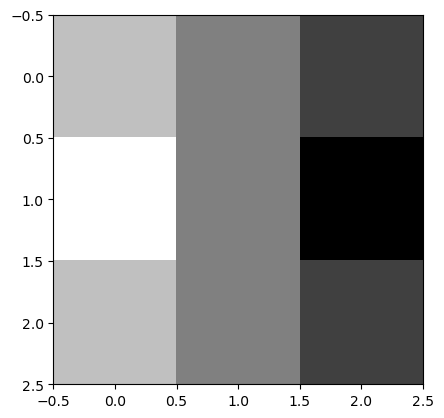

In [21]:
plt.imshow(w_x.reshape(w_x.shape[2], w_x.shape[3]), cmap = plt.cm.gray)
plt.show()

In [22]:
conv_layer = Convolution(w_x, b)

In [23]:
img = np.zeros((10,10))

In [24]:
img[:5,:] = 1

In [25]:
print(img)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


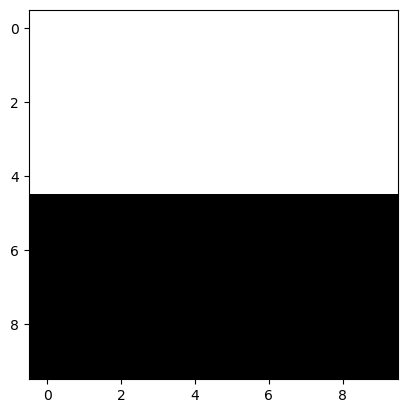

In [26]:
plt.imshow(img, cmap = plt.cm.gray)
plt.show()

In [27]:
img = img.reshape(1,1,*img.shape)
out = conv_layer.forward(img)
out = out.reshape(out.shape[2], out.shape[3])

In [28]:
print(out)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


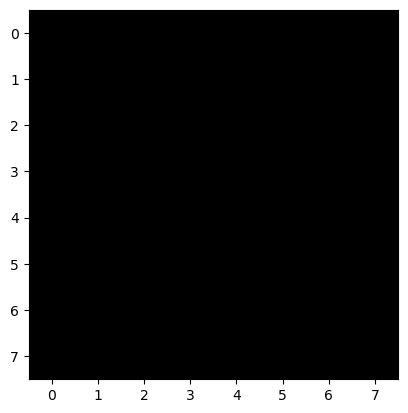

In [29]:
plt.imshow(out, cmap=plt.cm.gray)
plt.show()

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


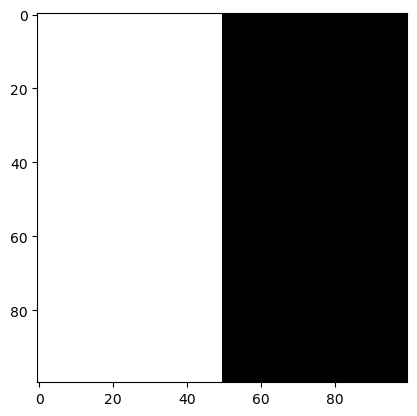

In [30]:
img = np.zeros((100,100))
img[:,:50] = 1
print(img)
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


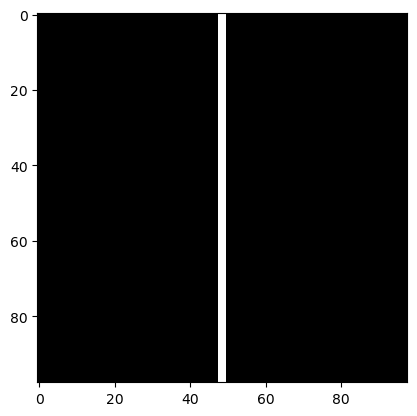

In [31]:
img = img.reshape(1,1,*img.shape)
out = conv_layer.forward(img)
out = out.reshape(out.shape[2], out.shape[3])
print(out)
plt.imshow(out, cmap = plt.cm.gray)
plt.show()

In [32]:
from matplotlib.image import imread

In [33]:
from PIL import Image
import numpy as np

img = Image.open("C:\\Users\\User\\OneDrive\\바탕 화면\\대학생활\\기타\\성격유형.png").convert('L')  # 'L' 모드는 Grayscale
img = np.array(img)  # numpy 배열 변환
print(img.shape)  # (H, W)

(2328, 1500)


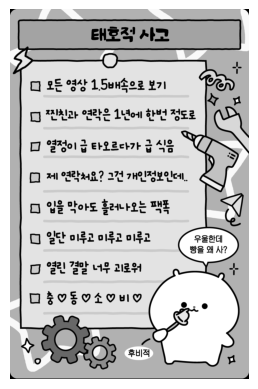

In [34]:
plt.imshow(img, cmap = plt.cm.gray)
plt.axis('off')
plt.show()

In [35]:
img = img.reshape(1, 1, *img.shape)
w_y = np.array([1,2,1,0,0,0,-1,-2,-1]).reshape(1,1,3,3)
b = 0
print("------------수평 sobel filter-----------")
print(w_y[0][0])

------------수평 sobel filter-----------
[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]


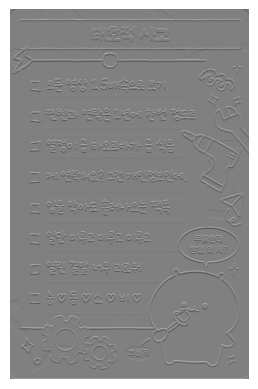

In [36]:
conv_layer = Convolution(w_y, b)
out = conv_layer.forward(img)
out = out.reshape(out.shape[2], out.shape[3])
plt.imshow(out, cmap = plt.cm.gray)
plt.axis('off')
plt.show()

In [37]:
# 수직 filter
w_x = np.array([1,0,-1,2,0,-2,1,0,-1]).reshape(1,1,3,3)
b = 0

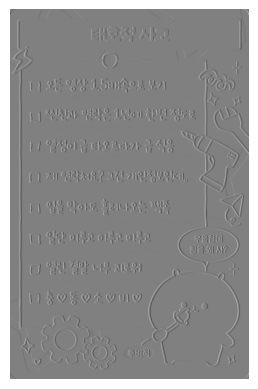

In [38]:
conv_layer = Convolution(w_x, b)
out = conv_layer.forward(img)
out = out.reshape(out.shape[2], out.shape[3])
plt.imshow(out, cmap = plt.cm.gray)
plt.axis('off')
plt.show()

In [39]:
X = np.array([[
    [
        [1,0,1],
        [0,1,0],
        [1,0,1]
    ],
    [
        [1,1,1],
        [1,0,1],
        [1,1,1]
    ]
            ],
    [
        [
            [1,1,1],
            [1,0,0],
            [1,0,0]
                  
        ],
        [
            [0,0,1],
            [0,0,1],
            [1,1,1]
        ]
    ]         
])

In [40]:
W = np.array([
        [
            [
                [1,0],
                [1,0]
            ],
            [
                [1,1],
                [0,0]
            ]
    
        ],
        [
            [
                [0,1],
                [0,1]
            ],
            [
                [0,0],
                [1,1]
            ]
         
        ]
])

In [41]:
b = np.array([1,2])

In [42]:
fourier = Convolution(W, b)

In [43]:
a = fourier.forward(X)
a

array([[[[4., 4.],
         [3., 3.]],

        [[4., 4.],
         [5., 5.]]],


       [[[3., 3.],
         [3., 2.]],

        [[3., 4.],
         [4., 4.]]]])

In [44]:
a+b

array([[[[5., 6.],
         [4., 5.]],

        [[5., 6.],
         [6., 7.]]],


       [[[4., 5.],
         [4., 4.]],

        [[4., 6.],
         [5., 6.]]]])

## 7.4.4 풀링 계층 구현하기

In [45]:

class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


In [114]:
#이미지 불러오기
img = imread("C:\\Users\\User\\OneDrive\\바탕 화면\\대학생활\\기타\\conv_img_example2.png")

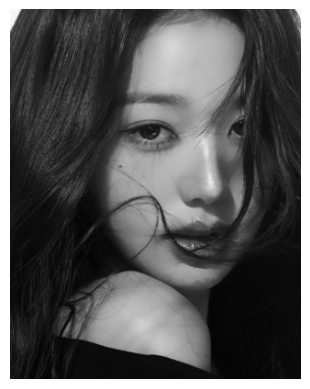

In [115]:
#이미지 확인
plt.imshow(img)
plt.axis('off')
plt.show()

In [116]:
#이미지 shape확인, 위의 코드에 맞는 shape으로 변신 (N*H*W*C -> N*C*H*W)
img = img.transpose(2,0,1)
img = img.reshape(1,*img.shape)
img.shape

(1, 4, 403, 317)

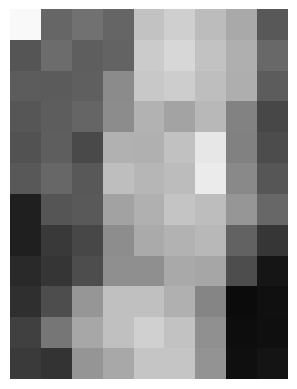

In [117]:
pooling_layer = Pooling(33,33,33)
out = pooling_layer.forward(img)
#한개확인
out = out[0]
#원래 shape으로 변경
out = out.transpose(1,2,0)

plt.imshow(out)
plt.axis('off')
plt.show()

In [118]:
# 풀링층 계산
X1 = np.array([[
    [
        [0,1,2],
        [3,7,4],
        [5,6,8] 
    ],
    [
        [8,0,1],
        [2,7,3],
        [4,5,6]
    ]
    
],
    [
        [
            [5,1,4],
            [2,0,2],
            [8,6,7]
        ],
        [
            [5,6,7],
            [3,8,4],
            [0,1,2]
        ]
                   
    ]
])

In [57]:
pool_layer2 = Pooling(2,2,1)
out2 = pool_layer2.forward(X1)
out2

array([[[[7., 7.],
         [7., 8.]],

        [[8., 7.],
         [7., 7.]]],


       [[[5., 4.],
         [8., 7.]],

        [[8., 8.],
         [8., 8.]]]])

# im2col

### N=1, C=1, H=3, W=3, FN=1, FH=2, FW=2, stride=1

In [103]:
# 입력 데이터
x = np.arange(9)
x = x.reshape(1,1,3,3)
print(x)

[[[[0 1 2]
   [3 4 5]
   [6 7 8]]]]


In [104]:
# im2col 시행
y = im2col(x,2,2)
print(y)

[[0. 1. 3. 4.]
 [1. 2. 4. 5.]
 [3. 4. 6. 7.]
 [4. 5. 7. 8.]]


In [105]:
#필터
w = np.array([[1, 0], [1, 0]]).reshape(1,1,2,2)
print(w)

[[[[1 0]
   [1 0]]]]


In [106]:
#필터도 im2col과 연산하기 편하게 하기 위해 변신
wc = w.reshape(1,-1).T
print(wc)

[[1]
 [0]
 [1]
 [0]]


In [107]:
# 행렬곱 결과
product = np.dot(y, wc)
print(product)

[[ 3.]
 [ 5.]
 [ 9.]
 [11.]]


In [108]:
# 출려데이터
out = product.reshape(1,2,2,1).transpose(0,3,1,2)
print(out)

[[[[ 3.  5.]
   [ 9. 11.]]]]


### N=1, C=2, H=3, W=3, FN=2, FH=2, FW=2, stride=1